# PyTorch MNIST MLP Autoencoder 

We will try to train simple MLP mnist autoencoder. 

## 1. Data 

In [86]:
import torch
import torchvision

In [87]:
trainloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=32, shuffle=True)

testloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root='./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

In [88]:
for batch in trainloader:
    print(batch[0].shape)
    print(batch[1])
    break

torch.Size([32, 1, 28, 28])
tensor([8, 1, 2, 6, 5, 5, 2, 3, 2, 1, 9, 4, 5, 9, 6, 4, 6, 1, 1, 8, 3, 7, 0, 5,
        0, 9, 3, 8, 6, 3, 2, 5])


In [89]:
print(len(trainloader) * 32)

60000


In [90]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from util import *

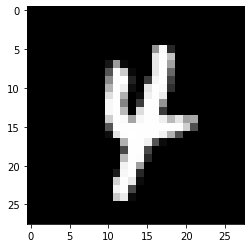

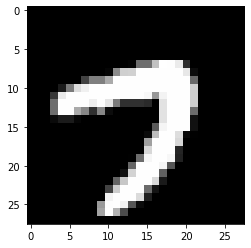

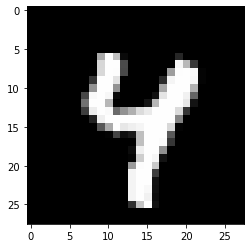

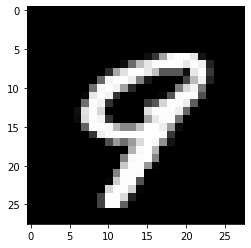

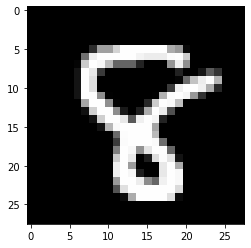

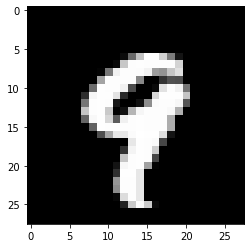

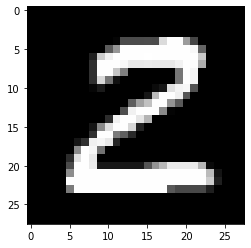

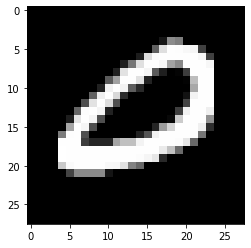

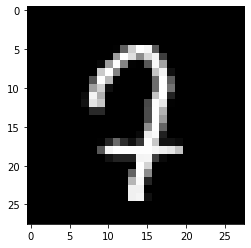

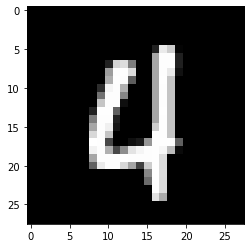

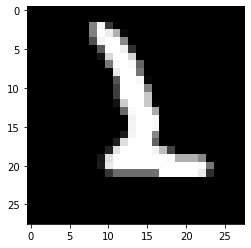

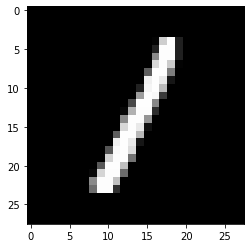

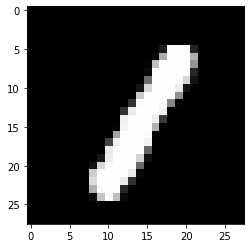

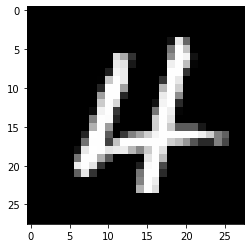

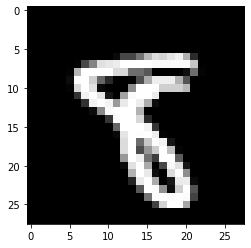

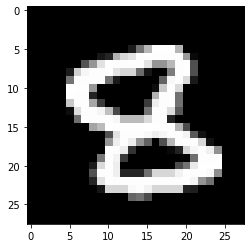

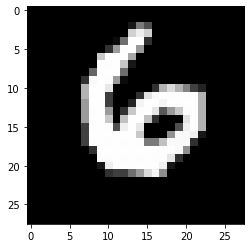

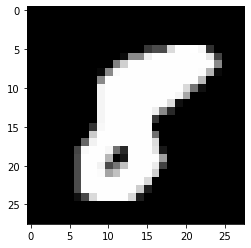

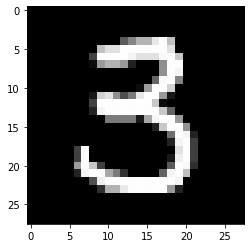

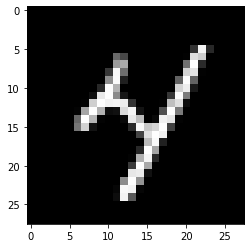

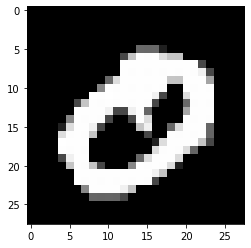

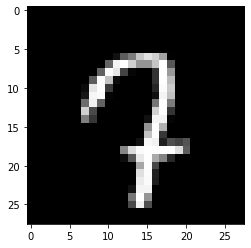

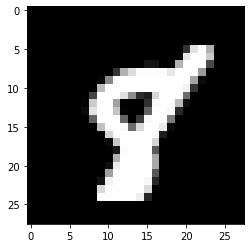

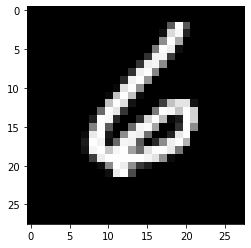

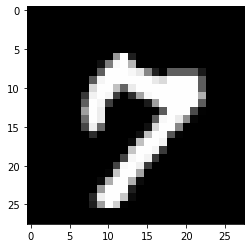

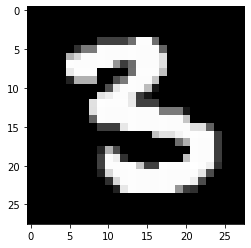

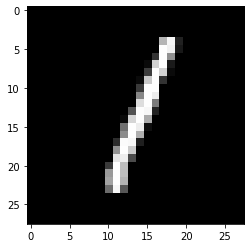

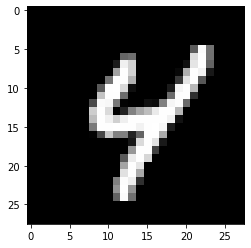

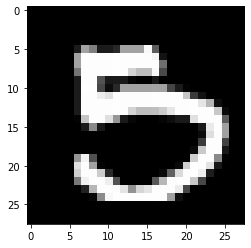

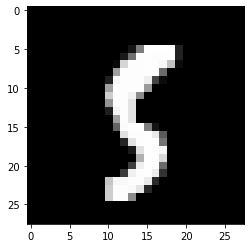

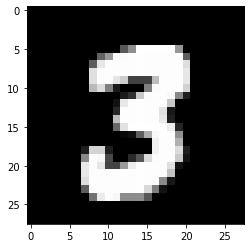

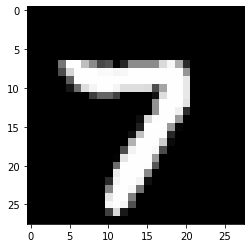

In [91]:
for batch in trainloader:
    images = batch[0]
    labels = batch[1]
    for image in images:
        plot_image = torch.movedim(image, 0, 2)
        plot_tensor(plot_image, False)
    break

## 2. Model 

In [92]:
import torch.nn as nn
import torch.nn.functional as F

In [112]:
latent_dim = 16

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # encoder  
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, latent_dim)
        
        # decoder 
        self.fc4 = nn.Linear(latent_dim, 64)
        self.fc5 = nn.Linear(64, 128)
        self.fc6 = nn.Linear(128, 28 * 28)
        

    def forward(self, x):
        # autoencoder  
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        return x.reshape((-1, 1, 28, 28))

In [113]:
net = Autoencoder()
net

Autoencoder(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=784, bias=True)
)

In [114]:
def get_model_size(net):
    """
    Function that calculates PyTorch model size. 
    Returns and prints. 
    Returns (num params, model size in MB). 
    """
    
    # taken from 
    # https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
    total_params = sum(p.numel() for p in net.parameters())
    
    # taken from 
    # https://discuss.pytorch.org/t/finding-model-size/130275/2 
    param_size = 0
    for param in net.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in net.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    
    print("Total number of parameters: ", total_params)
    print('model size: {:.3f}MB'.format(size_all_mb))

    return total_params, size_all_mb

In [115]:
num_params, mb_size = get_model_size(net)

Total number of parameters:  220320
model size: 0.840MB


In [116]:
def plot_batch(batch_arr):
    # plots the batch 
    for image in batch_arr:
        plot_img = image.detach().numpy()
        plot_numpy_img(np.squeeze(plot_img), False)    

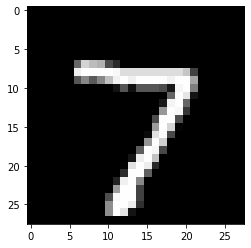

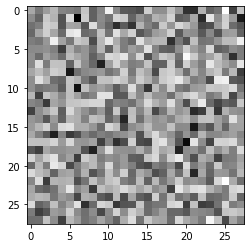

In [117]:
for batch in testloader:
    plot_batch(batch[0])
    out = net(batch[0])
    plot_batch(out)
    break

## 3. Train 

*GPU*:  

In [118]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [119]:
net.to(device)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=784, bias=True)
)

**Loss** (from [here](https://avandekleut.github.io/vae/)): 

In [120]:
def reconstruction(pred_img, true_img):
    return ((true_img - pred_img)**2).sum()

Ended up using MSELoss instead... 

In [121]:
loss = nn.MSELoss()

In [122]:
import torch.optim as optim
LEARNING_RATE = 0.001
MOMENTUM_VALUE = 0.9
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM_VALUE)

In [147]:
%%time
import time

enum = 0
elosses = []
NUM_EPOCHS = 50
start_time = time.time()
epoch_time = time.time()


for epoch in range(NUM_EPOCHS):
    enum += 1
    running_loss = 0.0 
    
    for data in trainloader:
        # 1. get the batch 
        batch = data[0].to(device)
        
        # 2. zero out grads 
        optimizer.zero_grad()
        
        # 3. forward + backward + optimize 
        pred_image = net(batch)
        loss_val = loss(pred_image, batch)
        loss_val.backward()
        optimizer.step()
        
        running_loss += loss_val 
        
    # loss stats 
    epoch_loss = (running_loss/len(trainloader)).cpu().detach().numpy()
    elosses.append(epoch_loss)
    print('Loss epoch {}: '.format(enum), epoch_loss)
    
    # timing 
    new_time = time.time()
    print("Total time (s): ", int(new_time - start_time))
    print("Epoch time (s): ", int(new_time - epoch_time))
    print("-------------------------")
    epoch_time = time.time()

Loss epoch 1:  0.79766893
Total time (s):  15
Epoch time (s):  15
-------------------------
Loss epoch 2:  0.7974029
Total time (s):  31
Epoch time (s):  15
-------------------------
Loss epoch 3:  0.7971125
Total time (s):  48
Epoch time (s):  16
-------------------------
Loss epoch 4:  0.7968016
Total time (s):  64
Epoch time (s):  16
-------------------------
Loss epoch 5:  0.7964579
Total time (s):  80
Epoch time (s):  16
-------------------------
Loss epoch 6:  0.79617506
Total time (s):  96
Epoch time (s):  16
-------------------------
Loss epoch 7:  0.7958873
Total time (s):  112
Epoch time (s):  15
-------------------------
Loss epoch 8:  0.7949816
Total time (s):  127
Epoch time (s):  15
-------------------------
Loss epoch 9:  0.79472834
Total time (s):  143
Epoch time (s):  15
-------------------------
Loss epoch 10:  0.79446113
Total time (s):  158
Epoch time (s):  15
-------------------------
Loss epoch 11:  0.7941243
Total time (s):  173
Epoch time (s):  15
--------------

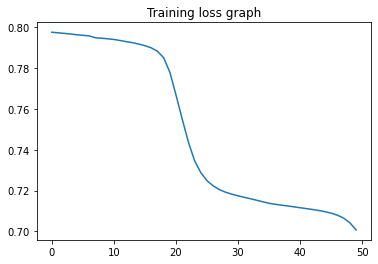

In [148]:
import matplotlib.pyplot as plt
plt.plot(elosses)
plt.title("Training loss graph")
plt.show()

## 4. Predict 

Original: 


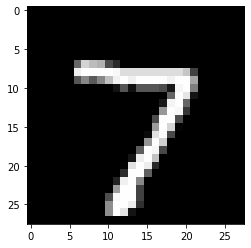

Prediction: 


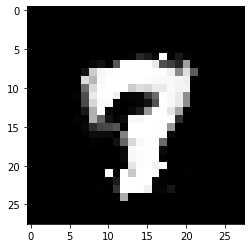

---------------------------------
Original: 


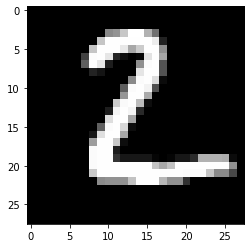

Prediction: 


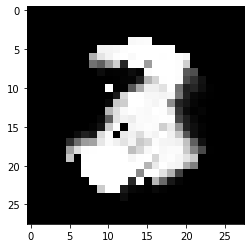

---------------------------------
Original: 


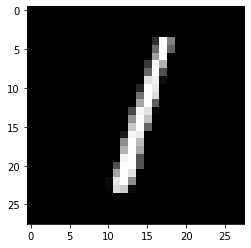

Prediction: 


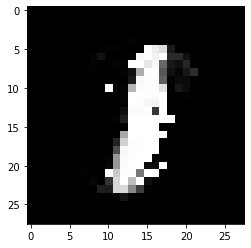

---------------------------------
Original: 


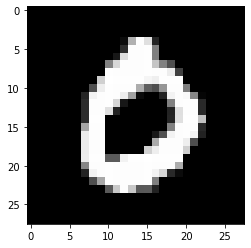

Prediction: 


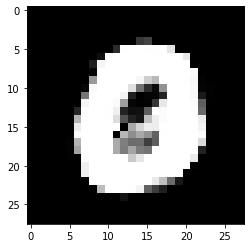

---------------------------------
Original: 


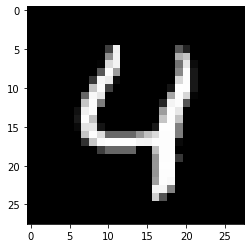

Prediction: 


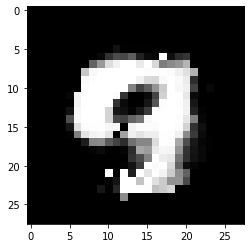

---------------------------------
Original: 


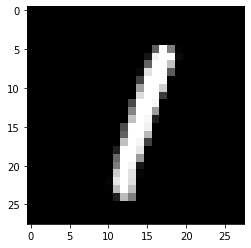

Prediction: 


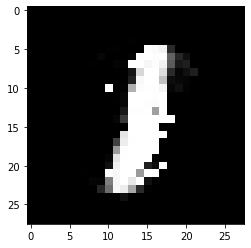

---------------------------------
Original: 


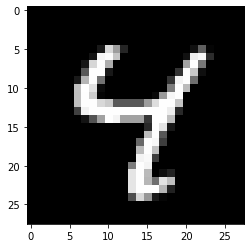

Prediction: 


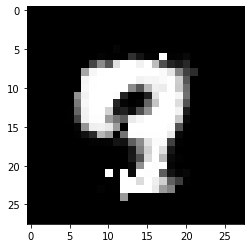

---------------------------------
Original: 


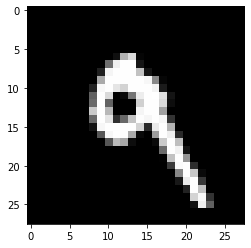

Prediction: 


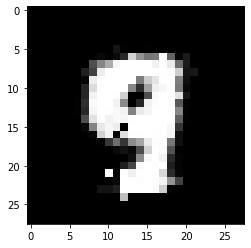

---------------------------------
Original: 


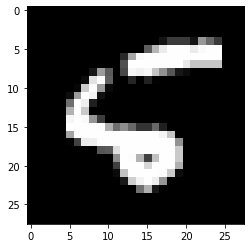

Prediction: 


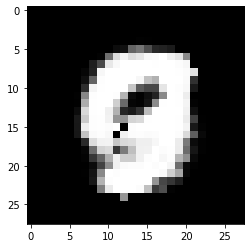

---------------------------------
Original: 


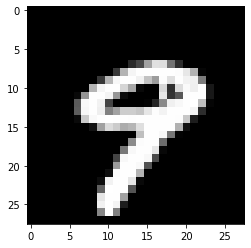

Prediction: 


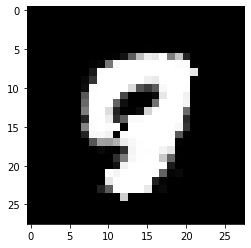

---------------------------------
Original: 


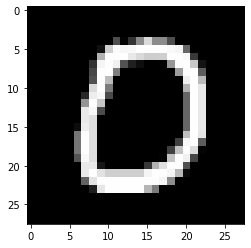

Prediction: 


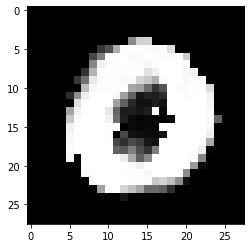

---------------------------------


In [168]:
i = 0
preds = []
with torch.no_grad():
    for batch in testloader:
        images = batch[0]
        print("Original: ")
        plot_batch(images)
        preds = net(images.to(device))
        print("Prediction: ")
        plot_batch(preds.cpu())   
        print("---------------------------------")
        
        i += 1
        
        if i > 10:
            break